In [1]:
options(warn=-1)
library(dplyr)
library(ggplot2)
library(mongolite)
library(lubridate)
library(cowplot)
library(ggcorrplot)
library(skimr)
library(Hmisc)
library(plotrix)
library(mongolite)
library(data.table)
library(caret)
library(rpart)
library(RColorBrewer)
library(partykit)
library(rattle)
library(ROSE)
library(randomForest)
library(kernlab)
library(e1071) 


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: 'cowplot'

The following object is masked from 'package:lubridate':

    stamp

Registered S3 method overwritten by 'skimr':
  method      from  
  print.spark pillar

Attaching package: 'skimr'

The following object is masked from 'package:stats':

    filter

Loadin

In [335]:
data_raw <- read.csv("hr_analytics.csv")
names(data_raw)[1] = "Age"
data_raw$Generation = cut(data_raw$Age,breaks = c(18,30,40,50,60), 
                labels=c("Millennials (18-30)","Experience (30-40)","Settle (40-50)","Old (50-60)"))
data_raw$Educational_Levels <-  ifelse(data_raw$Education == 1, "Without College D.",
                            ifelse(data_raw$Education == 2 , "College D.",
                                  ifelse(data_raw$Education == 3, "Bachelors D.",
                                        ifelse(data_raw$Education == 4, "Masters D.", "Phd D."))))

data_raw$CatYearManager <- ifelse(data_raw$YearsWithCurrManager <=1,"Recently Hired",
                             ifelse(data_raw$YearsWithCurrManager >1 & data_raw$YearsWithCurrManager<=4,"2-4 Years Hired",
                                   "Long Established Manager"))

In [56]:

col_numeric = mongo(db = "FIT5141", collection = "hr_numeric")
col_factor = mongo(db = "FIT5141", collection = "hr_factor")

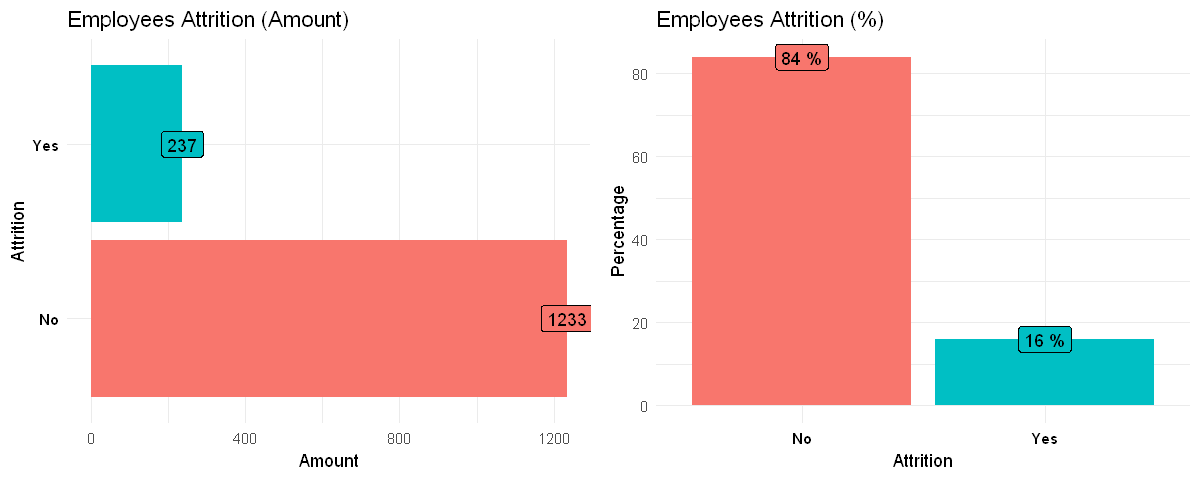

In [57]:
options(repr.plot.width=10, repr.plot.height=4) 

data <- col_numeric$aggregate('[
    {
        "$group":{"_id":"$Attrition", "Count":{"$sum":1}}
    }
]') 
names(data)[1] <- "Attrition"
im1 <- data %>% ggplot(aes(x=Attrition,y=Count,fill=Attrition)) + 
    geom_bar(stat = 'identity') + geom_label(aes(label=Count)) + theme_minimal() + coord_flip() +
    theme(legend.position = "none", axis.text.y = element_text(colour = 'black',face = 'bold')) + 
    labs(title="Employees Attrition (Amount)",y="Amount")
im2 <- data %>% mutate(pct=round(prop.table(Count),2)*100) %>% 
    ggplot(aes(x=Attrition,y=pct,fill=Attrition)) + geom_bar(stat='identity') + 
    geom_label(aes(label=paste(pct,'%'))) + theme_minimal()  + labs(title="Employees Attrition (%)",y="Percentage") + 
    theme(legend.position = "none", axis.text.x = element_text(colour = 'black',face = 'bold'))

plot_grid(im1,im2,nrow=1)

In [63]:
data1 <- col_factor$aggregate('[
    {
        "$group":{"_id":"$Gender","Count":{"$sum":1}}
    }
]') 
data1

data2 <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            }
    },
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0 } 
    },
    {
        "$group":{"_id":{"Gender":"$Gender"}, "AvgSalary":{"$avg":"$Age"}}
    }
]')

data2 <- as.data.frame(matrix(unlist(data2),byrow=F, nrow(data2),ncol(data2)))
names(data2) <- c("Gender","Mean Age")
data2

_id,Count
Male,882
Female,588


Gender,Mean Age
Male,36.6530612244898
Female,37.3299319727891


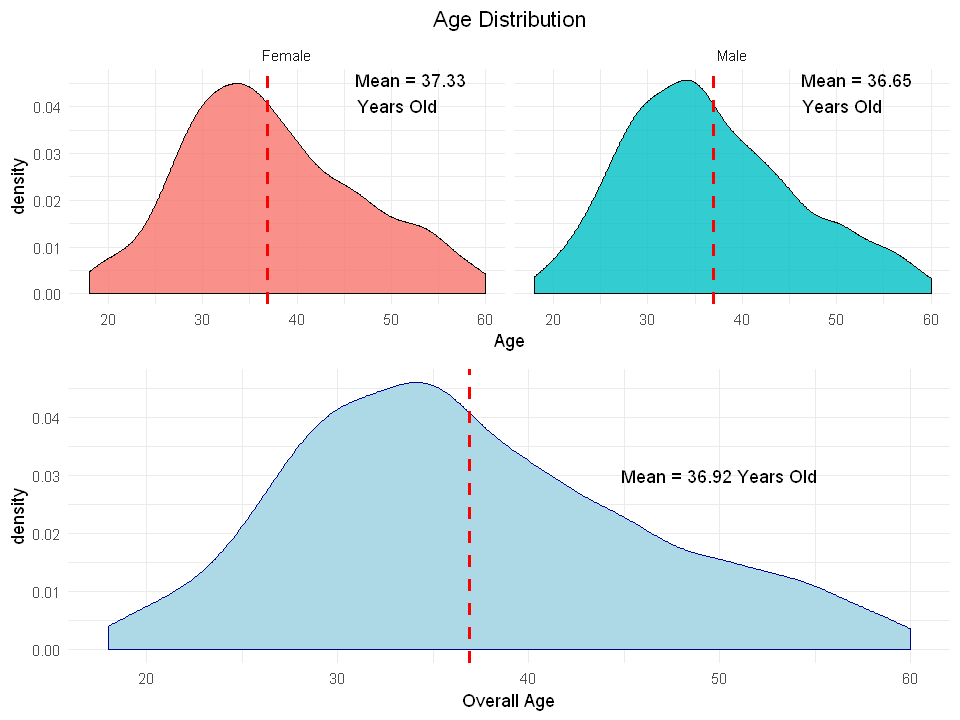

In [150]:
options(repr.plot.width=8, repr.plot.height=6) 

dat_text <- data.frame(
  label = c("Mean = 37.33 \n Years Old", "Mean = 36.65 \n Years Old"),
  Gender   = c("Female", "Male")
)

data <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            }
    }, 
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0 } 
    },
    {
        "$project": {"Age":1,"Gender":1}
    }
]') 

gender.dist <- data  %>% ggplot(aes(x=Age)) + 
    geom_density(aes(fill=Gender), alpha=0.8, show.legend=FALSE) + facet_wrap(~Gender) + theme_minimal() + 
    geom_vline(aes(xintercept=mean(Age)),
                color="red", linetype="dashed", size=1) + labs(title="Age Distribution") + 
    theme(plot.title=element_text(hjust=0.5)) + 
    geom_text(
      data    = dat_text,
      mapping = aes(x = 45, y = 0.03, label = label),
      hjust   = -0.1,
      vjust   = -1
    )

overall.dist <- data  %>% filter(!is.na(Age)) %>% 
    ggplot(data=data, mapping=aes(x=Age)) + geom_density(color="darkblue", fill="lightblue") + 
    geom_vline(aes(xintercept=mean(Age)),
                color="red", linetype="dashed", size=1) +  theme_minimal() + labs(x="Overall Age") + 
    annotate("text", label = "Mean = 36.92 Years Old", x = 50, y = 0.03, color = "black")

plot_grid(gender.dist, overall.dist, nrow=2)

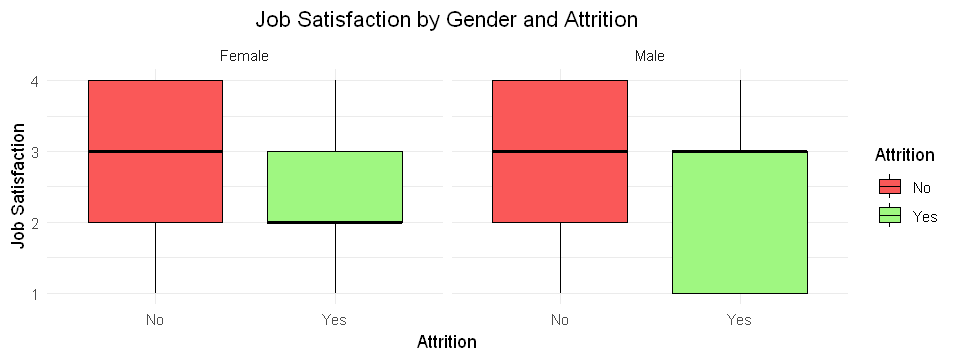

In [136]:
# distribtuion of job satisfaction
options(repr.plot.width=8, repr.plot.height=3) 

data <- col_factor$find(fields='{"_id":0,"Gender":1,"Attrition":1,"JobSatisfaction":1}')
data$JobSatisfaction <- as.integer(data$JobSatisfaction)

box.attrition <- data %>% select(Attrition, JobSatisfaction, Gender) %>% 
ggplot(aes(x=Attrition, y=JobSatisfaction, fill=Attrition)) + geom_boxplot(color="black") + theme_minimal() + facet_wrap(~Gender) + 
scale_fill_manual(values=c("#FA5858", "#9FF781")) + labs(title="Job Satisfaction by Gender and Attrition",y="Job Satisfaction") +
theme(plot.title = element_text(hjust = 0.5))
box.attrition

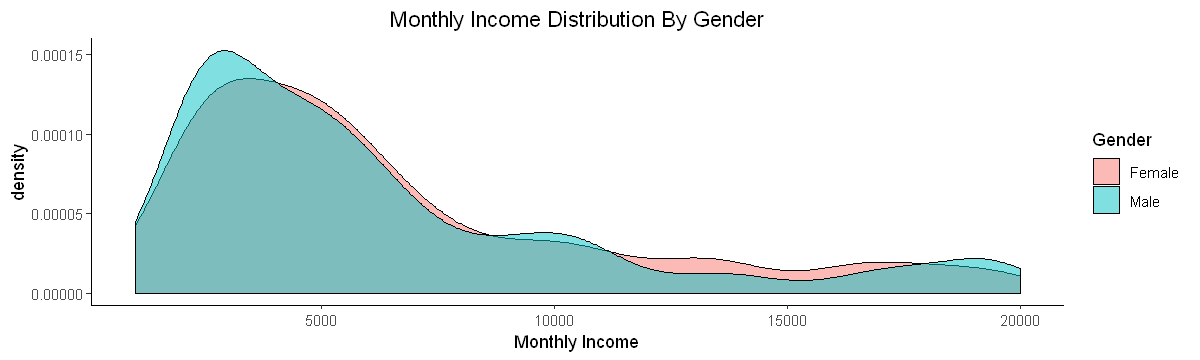

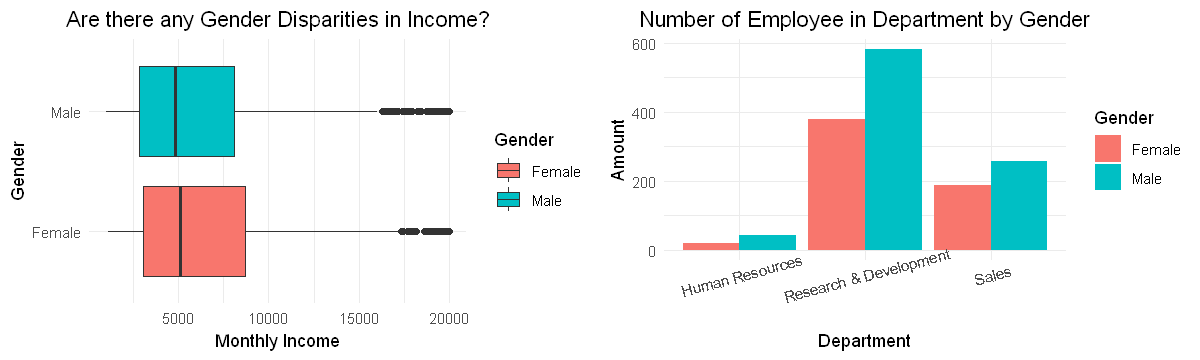

In [156]:
options(repr.plot.width=10, repr.plot.height=3) 
data <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            }
    }, 
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0} 
    },
    {
        "$project": {"MonthlyIncome":1,"Gender":1, "Attrition":1,"Department":1}
    }
]') 

p1 <- data %>% ggplot(aes(x=MonthlyIncome, fill=Gender)) + geom_density(alpha=0.5) + theme_classic() + 
    labs(title="Monthly Income Distribution By Gender",x="Monthly Income") + 
    theme(plot.title = element_text(hjust=0.5))

p2 <- data %>% group_by(Attrition) %>% ggplot(aes(x=Gender,y=MonthlyIncome,fill=Gender)) + geom_boxplot() + coord_flip() + 
    labs(title="Are there any Gender Disparities in Income?", y="Monthly Income") + 
    theme_minimal() + theme(plot.title = element_text(hjust=0.5))

p3 <- data %>% select(Department,Gender) %>% group_by(Department,Gender) %>% summarise(Count=n()) %>%
    ggplot(aes(x=Department,y=Count,fill=Gender)) + geom_bar(stat='identity',position = 'dodge') + theme_minimal() + 
    labs(title="Number of Employee in Department by Gender",y='Amount') + 
theme(plot.title = element_text(hjust=0.5), axis.text.x = element_text(angle = 15))
p1
plot_grid(p2,p3, nrow=1)

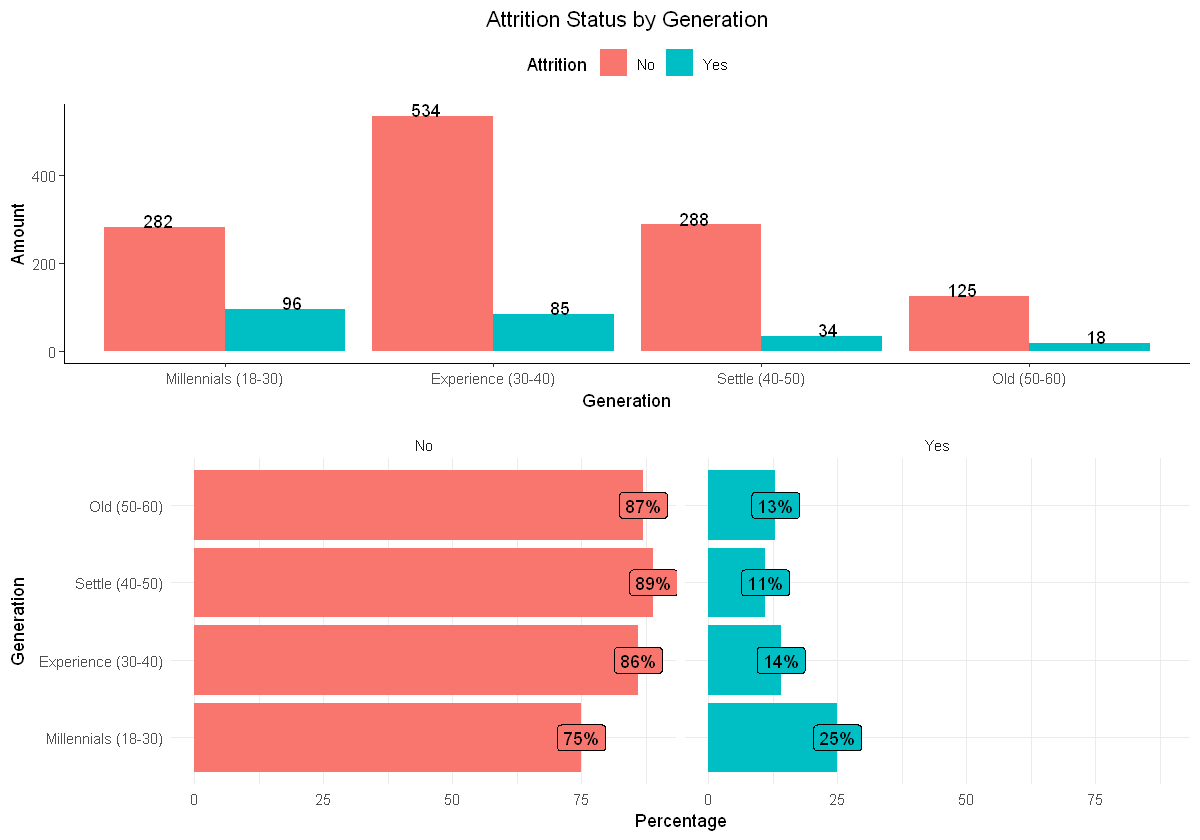

In [198]:
# alright, the distribution is not really greate, probably need to take care more about this classification's criteria 
# now, let the the attrition based on this age 
# let device employee in different generation
# from 18-30, 31 - 40, 41-50, 51-60 with corresponding name: Millennials, Experience, Settle, Old
data <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            }
    }, 
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0} 
    },
    {
        "$project": {"_id":0, "Age":1, "Attrition":1, "MonthlyIncome":1, "NumCompaniesWorked":1}
    }
]') 
data$Generation = cut(data$Age,breaks = c(18,30,40,50,60), 
                labels=c("Millennials (18-30)","Experience (30-40)","Settle (40-50)","Old (50-60)"))
options(repr.plot.width=10, repr.plot.height=7)

p1<-data %>% select(Generation, Attrition) %>% filter(!is.na(Generation)) %>% group_by(Generation,Attrition) %>% summarise(Count=n()) %>% 
    ggplot(aes(x=Generation,y=Count,fill=Attrition)) + geom_bar(stat = 'identity', position = 'dodge') + 
    geom_text(aes(x=Generation,y=Count,label=Count),position = position_dodge(width = 1),vjust=0.01) + theme_classic() + 
    theme(legend.position = "top", plot.title = element_text(hjust=0.5)) + 
    labs(title="Attrition Status by Generation", x= "Generation", y="Amount")
p2 <-data %>% select(Generation, Attrition) %>% filter(!is.na(Generation)) %>% group_by(Generation,Attrition) %>% summarise(Count=n()) %>% 
    mutate(pct=round(prop.table(Count),2)*100) %>%
    ggplot(aes(x=Generation,y=pct,fill=Attrition)) + geom_bar(stat = 'identity') +
    geom_label(aes(label=paste0(pct,"%"),fill=Attrition)) + facet_grid(~Attrition) + coord_flip() + theme_minimal() + 
    theme(legend.position = "none") + labs(y="Percentage",x="Generation")
plot_grid(p1,p2,nrow=2)

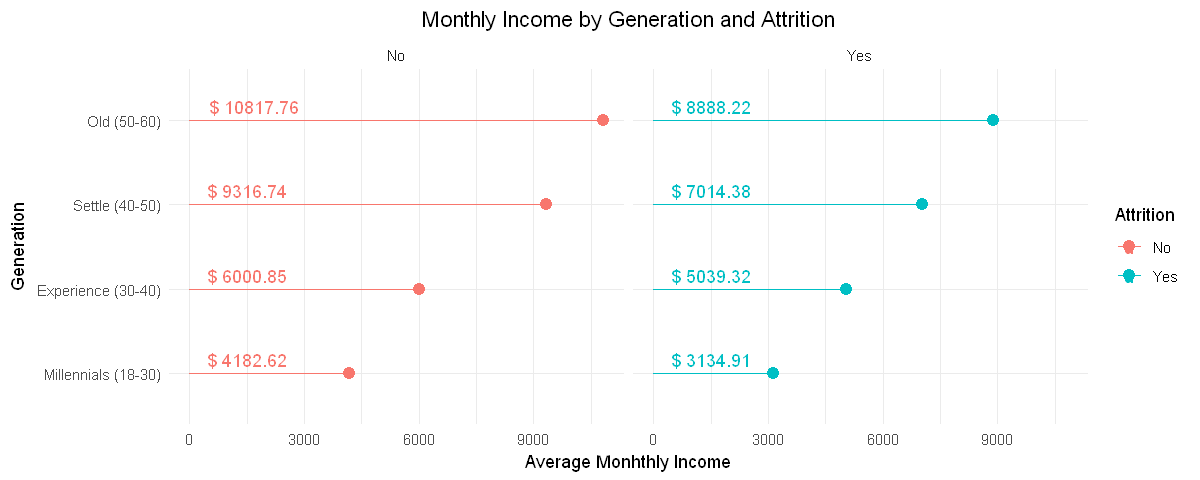

In [199]:
options(repr.plot.width=10, repr.plot.height=4)
data %>% filter(!is.na(Generation)) %>% group_by(Generation,Attrition) %>% summarise(avg=mean(MonthlyIncome)) %>% 
    ggplot(aes(x=Generation,y=avg,col=Attrition)) + geom_point(size=3) + facet_grid(~Attrition) + coord_flip() + theme_minimal() + 
    geom_segment(aes(x=Generation,xend=Generation,y=0,yend=avg)) + 
    geom_text(aes(x=Generation,y=50, hjust=-0.2, vjust=-0.5, label=paste("$",round(avg,2)))) + 
    labs(title="Monthly Income by Generation and Attrition",y="Average Monhthly Income") + 
    theme(plot.title = element_text(hjust=0.5))

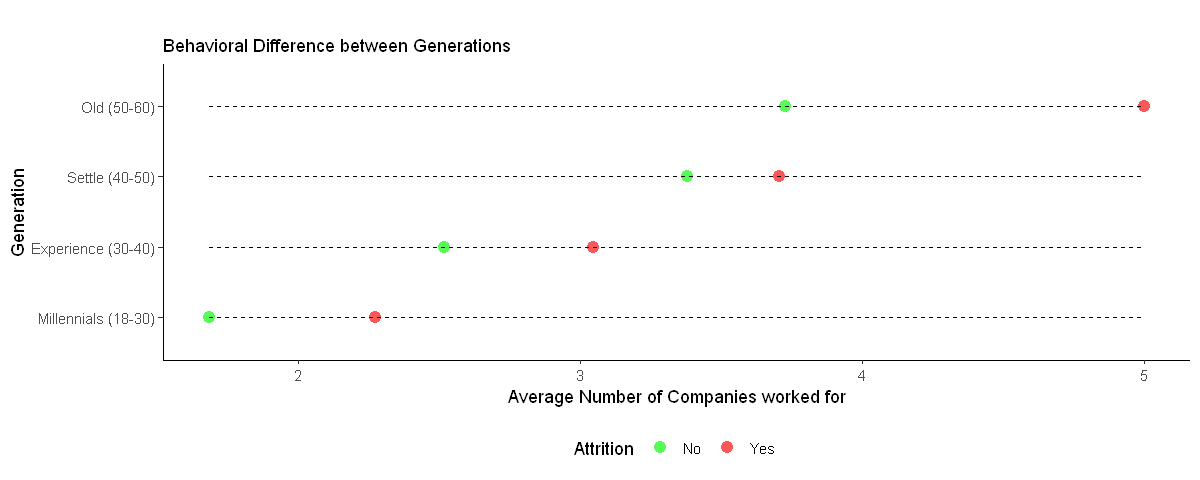

In [201]:
p3 <- data %>% filter(!is.na(Generation)) %>% select(Generation, NumCompaniesWorked, Attrition) %>% group_by(Generation, Attrition) %>%
        summarise(avg=mean(NumCompaniesWorked)) %>% ggplot(aes(x=Generation, y=avg, color=Attrition)) + 
        geom_point(size=3) +  # Draw points
        geom_segment(aes(x=Generation, 
                           xend=Generation, 
                           y=min(avg), 
                           yend=max(avg)), 
                           linetype="dashed", 
                           size=0.1,
                           color="black") + theme_classic()+
      labs(title="", subtitle="Behavioral Difference between Generations", y="Average Number of Companies worked for",
          x="Generation") +  coord_flip() + scale_color_manual(values=c("#58FA58", "#FA5858")) + 
      theme(legend.position="bottom",plot.title=element_text(face = 'bold',size=12,hjust=0.5))
p3

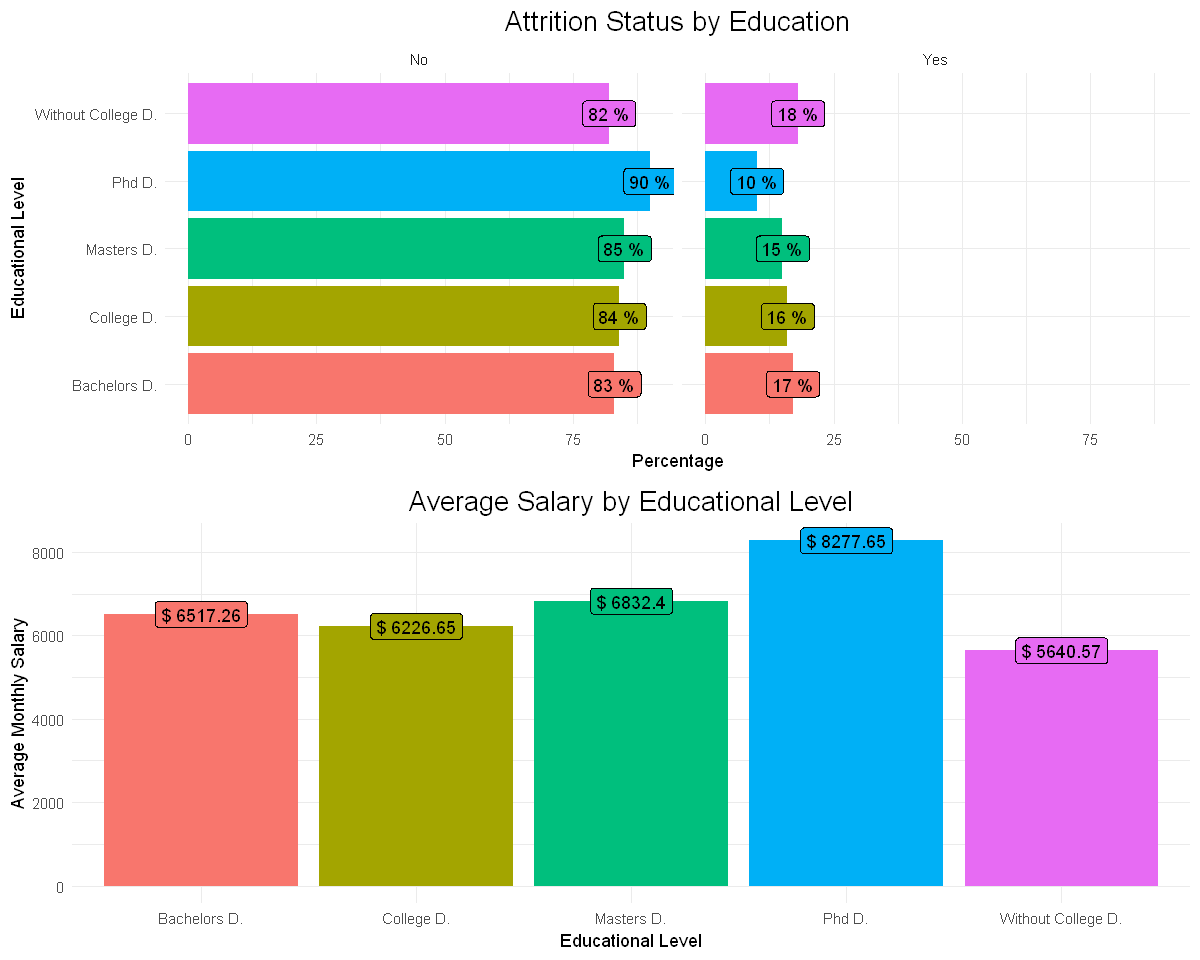

In [202]:
# What about Education and Attrition and Average Salary for Education
options(repr.plot.width=10, repr.plot.height=8) 

data <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            } 
    }, 
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0} 
    },
    {
        "$project": {"_id":0, "Education":1, "Attrition":1, "MonthlyIncome":1}
    }
]') 


data$Educational_Levels <-  ifelse(data$Education == 1, "Without College D.",
                            ifelse(data$Education == 2 , "College D.",
                                  ifelse(data$Education == 3, "Bachelors D.",
                                        ifelse(data$Education == 4, "Masters D.", "Phd D."))))
p1 <- data %>% group_by(Educational_Levels,Attrition) %>% summarise(Count=n()) %>% mutate(pct=round(prop.table(Count),2)*100) %>%
    arrange(desc(pct)) %>%
    ggplot(aes(x=Educational_Levels,y=pct, fill=Educational_Levels)) + geom_bar(stat = 'identity') + 
    facet_wrap(~Attrition) + coord_flip() + geom_label(aes(label=paste(pct,'%')),show.legend = FALSE) + theme_minimal()  + 
    labs(title="Attrition Status by Education", y="Percentage", x="Educational Level")+
    theme(legend.position = 'none', plot.title = element_text(hjust=0.5,size=16))

p2 <- data %>% group_by(Educational_Levels) %>% summarise(avg=mean(MonthlyIncome)) %>% arrange(desc(avg)) %>% 
    ggplot(aes(x=Educational_Levels, y=avg, fill=Educational_Levels)) + geom_bar(stat = 'identity') + 
    geom_label(aes(label=paste("$",round(avg,2)))) + theme_minimal() + 
    labs(title="Average Salary by Educational Level",x="Educational Level",y="Average Monthly Salary") + 
    theme(legend.position = 'none', plot.title=element_text(hjust=0.5,size=16)) 

plot_grid(p1,p2,nrow=2) 

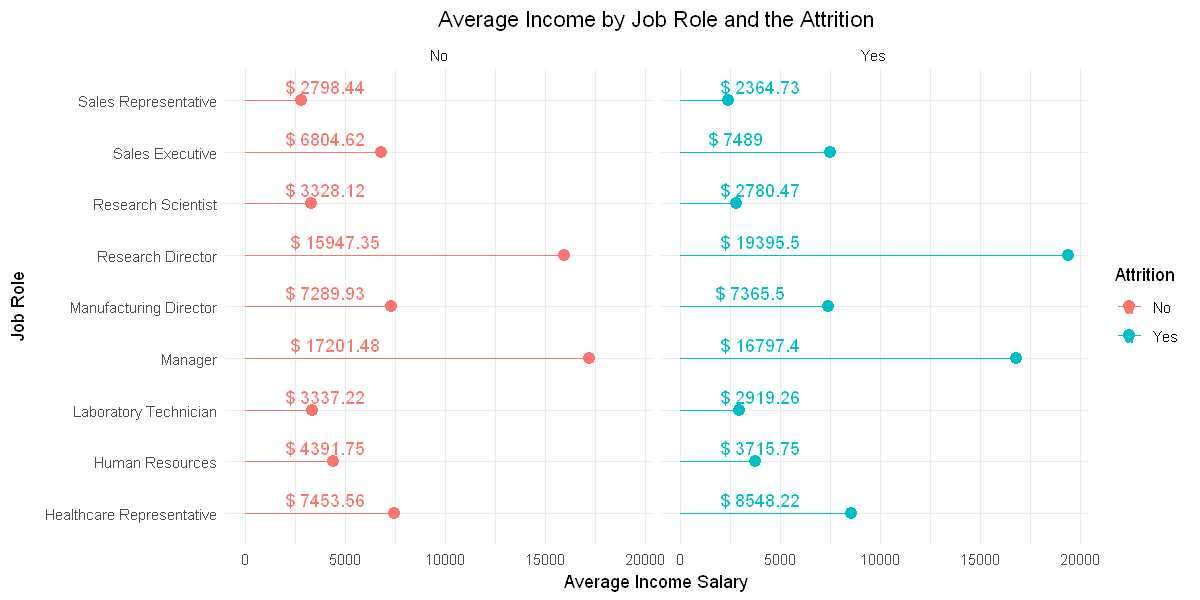

In [231]:
options(repr.plot.width=10, repr.plot.height=5) 
# attrition in department
# seem like the sale marketing have equal number of people who want to quit them to the Research Department.
# Let see average salary of department from attrition status

data <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            }
    }, 
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0} 
    },
    {
        "$group":{"_id":{"Attrition":"$Attrition", "JobRole":"$JobRole"}, "AvgIncome":{"$avg":"$MonthlyIncome"}}
    }
]')

data <- as.data.frame(matrix(unlist(data),byrow=F, nrow(data),ncol(data)+1))
names(data) <- c("Attrition","JobRole","AvgIncome")
data$AvgIncome <- as.double(as.character(data$AvgIncome))
data$AvgIncome <- round(data$AvgIncome,2)

p2 <- data %>% ggplot(aes(x=JobRole,y=AvgIncome,color=Attrition)) + geom_point(size=3) +
    geom_segment(aes(x=JobRole,xend=JobRole,y=0,yend=AvgIncome)) + facet_wrap(~Attrition) + 
    geom_text(aes(x=JobRole, y=0.2, label=paste("$",AvgIncome)),hjust=-0.5, vjust=-0.5, angle=360) +
    coord_flip() + theme_minimal() + labs(title="Average Income by Job Role and the Attrition",
                                         x= "Job Role", y="Average Income Salary") + 
    theme(plot.title = element_text(hjust=0.5))
p2

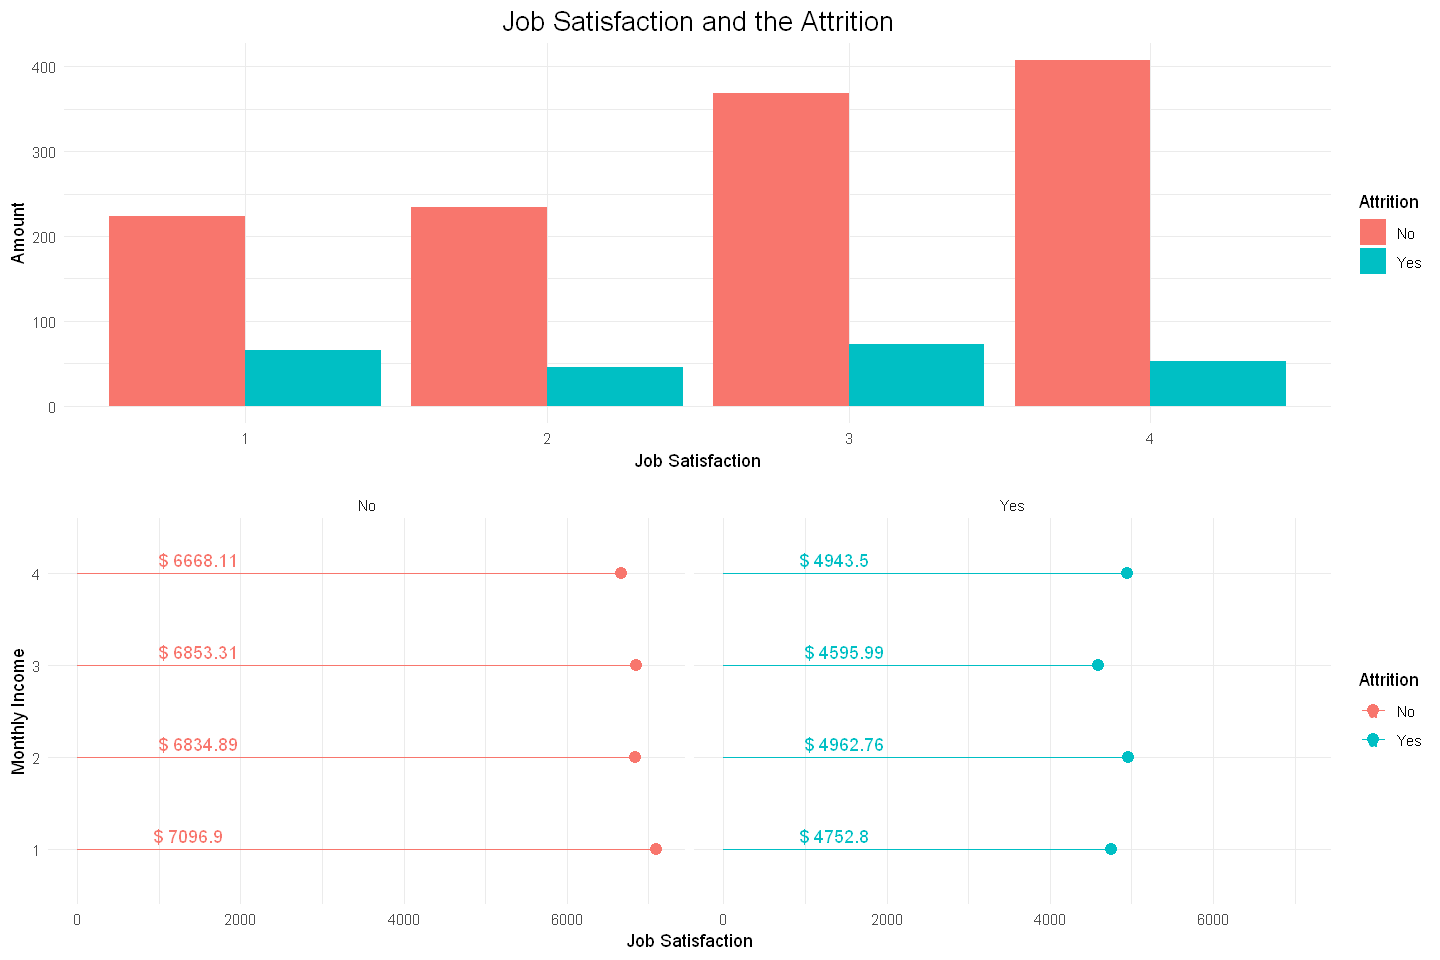

In [263]:
# job satisfaction
options(repr.plot.width=12, repr.plot.height=8) 

p1 <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            }
    }, 
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0} 
    },
    {
        "$group":{"_id":{"Attrition":"$Attrition", "JobSatisfaction":"$JobSatisfaction"}, "Count":{"$sum":1}}
    }
]') 

p1 <- as.data.frame(matrix(unlist(p1),byrow=F, nrow(p1),ncol(p1)+1))
names(p1) <- c("Attrition","JobSatisfaction","Count")
p1$Count <- as.integer(as.character(p1$Count))

p1 <- p1 %>% ggplot(aes(x=JobSatisfaction,y=Count,fill=Attrition)) + geom_bar(stat='identity', position='dodge') + theme_minimal() + 
    labs(title="Job Satisfaction and the Attrition", x="Job Satisfaction",y="Amount") + 
    theme(plot.title=element_text(hjust=0.5,size=16))

p2 <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            }
    }, 
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0} 
    },
    {
        "$group":{"_id":{"Attrition":"$Attrition", "JobSatisfaction":"$JobSatisfaction"}, "avg":{"$avg":"$MonthlyIncome"}}
    }
]')
p2 <- as.data.frame(matrix(unlist(p2),byrow=F, nrow(p2),ncol(p2)+1))
names(p2) <- c("Attrition","JobSatisfaction","avg")
p2$avg <- as.double(as.character(p2$avg))

p2 <- p2 %>% ggplot(aes(x=JobSatisfaction,y=avg,color=Attrition)) + geom_point(size=3) + facet_wrap(~Attrition) + coord_flip() + 
    theme_minimal() + geom_segment(aes(x=JobSatisfaction,xend=JobSatisfaction,y=0,yend=avg)) + 
    geom_text(aes(x=JobSatisfaction,y=500, hjust=-0.5,vjust=-0.5,label=paste("$",round(avg,2)))) + 
    labs(x="Monthly Income",y="Job Satisfaction")

plot_grid(p1,p2,nrow=2)


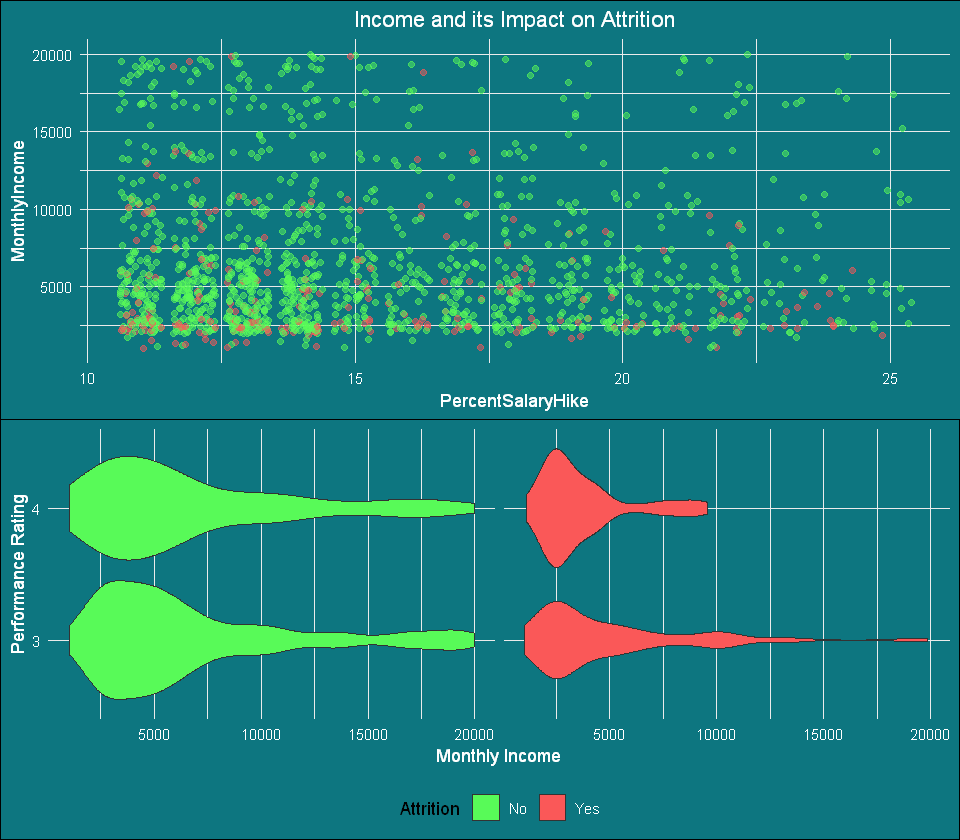

In [271]:
# monthly salary and percent salary hike
options(repr.plot.width=8, repr.plot.height=7) 

data <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            }
    }, 
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0} 
    },
    {
        "$project":{"_id":0, "Attrition":1,"PercentSalaryHike":1, "MonthlyIncome":1, "PerformanceRating":1}
    }
]')

p1 <- data %>% select(Attrition, PercentSalaryHike, MonthlyIncome) %>% 
    ggplot(aes(x=PercentSalaryHike, y=MonthlyIncome)) + geom_jitter(aes(col=Attrition), alpha=0.5) + 
    theme(legend.position="none") + scale_color_manual(values=c("#58FA58", "#FA5858")) + theme_minimal()+ 
    labs(title="Income and its Impact on Attrition") + 
    theme(plot.title=element_text(hjust=0.5, color="white"), 
          plot.background=element_rect(fill="#0D7680"), legend.position="none",
          axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
          axis.title=element_text(colour="white"))

p2 <- data %>% select(PerformanceRating, MonthlyIncome, Attrition) %>% group_by(factor(PerformanceRating), Attrition) %>% 
    ggplot(aes(x=factor(PerformanceRating), y=MonthlyIncome, fill=Attrition)) + 
    geom_violin() + coord_flip() + facet_wrap(~Attrition) + 
    scale_fill_manual(values=c("#58FA58", "#FA5858")) + theme_minimal() + 
    theme(legend.position="bottom", strip.background = element_blank(), strip.text.x = element_blank(), 
         plot.title=element_text(hjust=0.5, color="white"), plot.background=element_rect(fill="#0D7680"),
                                                        axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
                                                        axis.title=element_text(colour="white"), 
     legend.text=element_text(color="white")) + 
labs(x="Performance Rating",y="Monthly Income") 


plot_grid(p1, p2, nrow=2)

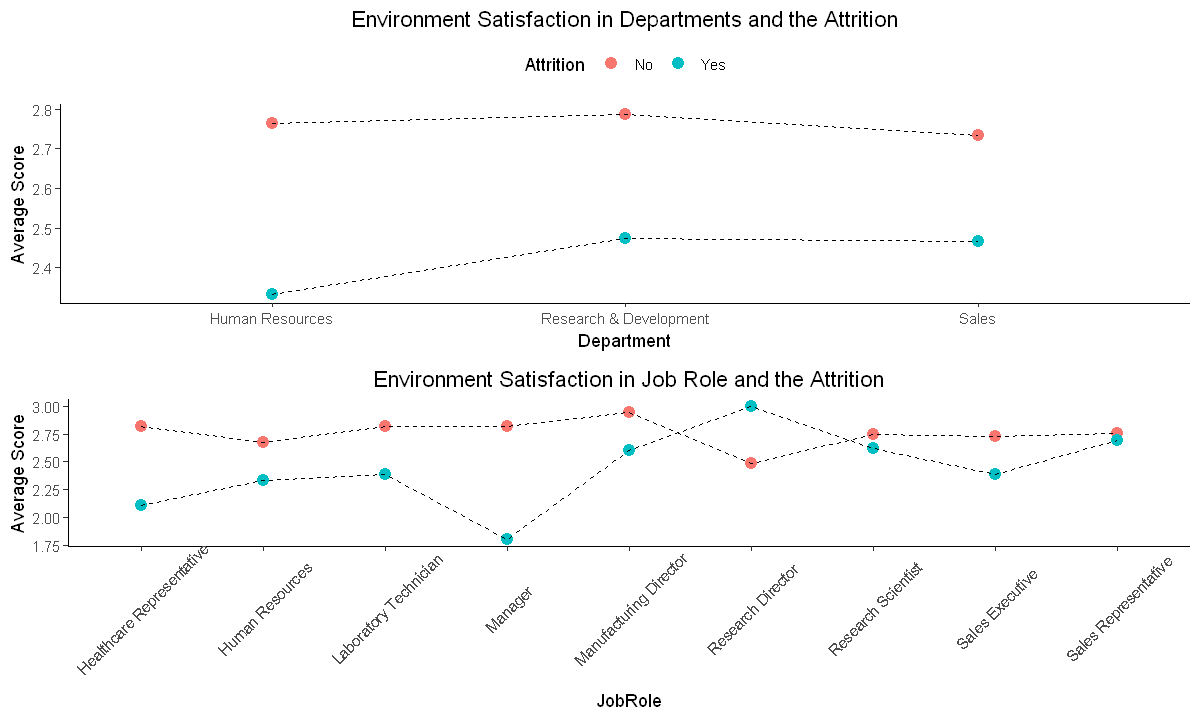

In [281]:

options(repr.plot.width=10, repr.plot.height=6) 

data <- col_factor$aggregate('[
    {
    "$group":{"_id":{"Attrition":"$Attrition", "Department":"$Department"}, 
              "avg":{"$avg":{"$toInt":"$EnvironmentSatisfaction"}}}
    }
]')
data <- as.data.frame(matrix(unlist(data),byrow=F, nrow(data),ncol(data)+1))
names(data) <- c("Attrition","Department","avg")
data$avg <- as.double(as.character(data$avg))

p1 <- data %>% ggplot(aes(x=Department,y=avg)) + 
    geom_point(aes(color=Attrition),size=3) + geom_line(aes(group=Attrition),linetype='dashed',color='#000000') +
    labs(title="Environment Satisfaction in Departments and the Attrition", y="Average Score") + 
    theme_classic() + theme(legend.position = "top", plot.title=element_text(hjust=0.5)) 

data <- col_factor$aggregate('[
    {
    "$group":{"_id":{"Attrition":"$Attrition", "JobRole":"$JobRole"}, 
              "avg":{"$avg":{"$toInt":"$EnvironmentSatisfaction"}}}
    }
]')
data <- as.data.frame(matrix(unlist(data),byrow=F, nrow(data),ncol(data)+1))
names(data) <- c("Attrition","JobRole","avg")
data$avg <- as.double(as.character(data$avg))

p2 <- data %>% ggplot(aes(x=JobRole,y=avg)) + 
    geom_point(aes(color=Attrition),size=3) + geom_line(aes(group=Attrition),linetype='dashed',color='#000000') + 
    theme_classic() + labs(title="Environment Satisfaction in Job Role and the Attrition", y="Average Score") + 
    theme(plot.title=element_text(hjust=0.5), axis.text.x = element_text(angle = 45,vjust=0.6), legend.position = 'none')
plot_grid(p1,p2,nrow=2)

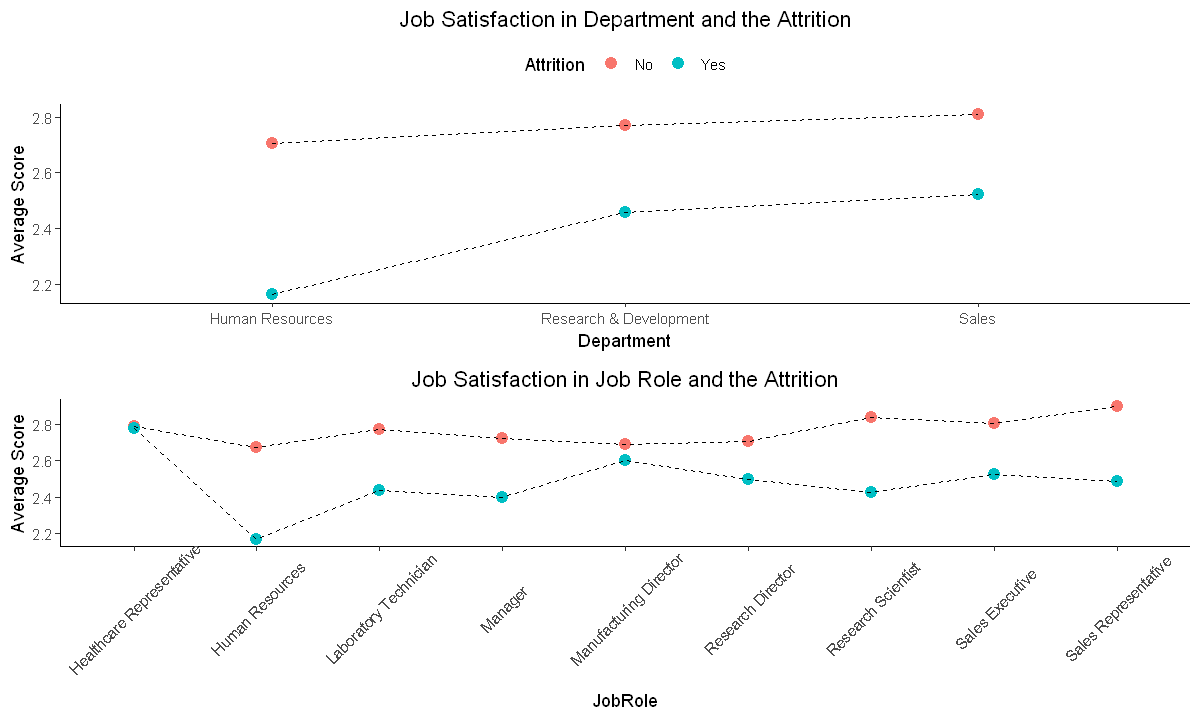

In [282]:
# JobSatisfaction
options(repr.plot.width=10, repr.plot.height=6) 

data <- col_factor$aggregate('[
    {
    "$group":{"_id":{"Attrition":"$Attrition", "Department":"$Department"}, 
              "avg":{"$avg":{"$toInt":"$JobSatisfaction"}}}
    }
]')
data <- as.data.frame(matrix(unlist(data),byrow=F, nrow(data),ncol(data)+1))
names(data) <- c("Attrition","Department","avg")
data$avg <- as.double(as.character(data$avg))

p1 <- data %>% ggplot(aes(x=Department,y=avg)) + 
    geom_point(aes(color=Attrition),size=3) + geom_line(aes(group=Attrition),linetype='dashed',color='#000000') +
    labs(title="Job Satisfaction in Department and the Attrition", y="Average Score") + 
    theme_classic() + theme(plot.title=element_text(hjust=0.5), legend.position = "top")

data <- col_factor$aggregate('[
    {
    "$group":{"_id":{"Attrition":"$Attrition", "JobRole":"$JobRole"}, 
              "avg":{"$avg":{"$toInt":"$JobSatisfaction"}}}
    }
]')
data <- as.data.frame(matrix(unlist(data),byrow=F, nrow(data),ncol(data)+1))
names(data) <- c("Attrition","JobRole","avg")
data$avg <- as.double(as.character(data$avg))


p2 <- data %>% ggplot(aes(x=JobRole,y=avg)) + 
    geom_point(aes(color=Attrition),size=3) + geom_line(aes(group=Attrition),linetype='dashed',color='#000000') + 
    labs(title="Job Satisfaction in Job Role and the Attrition", y="Average Score") + 
    theme_classic() + theme(plot.title=element_text(hjust=0.5),axis.text.x = element_text(angle = 45,vjust=0.6), legend.position = 'none')
plot_grid(p1,p2,nrow=2)

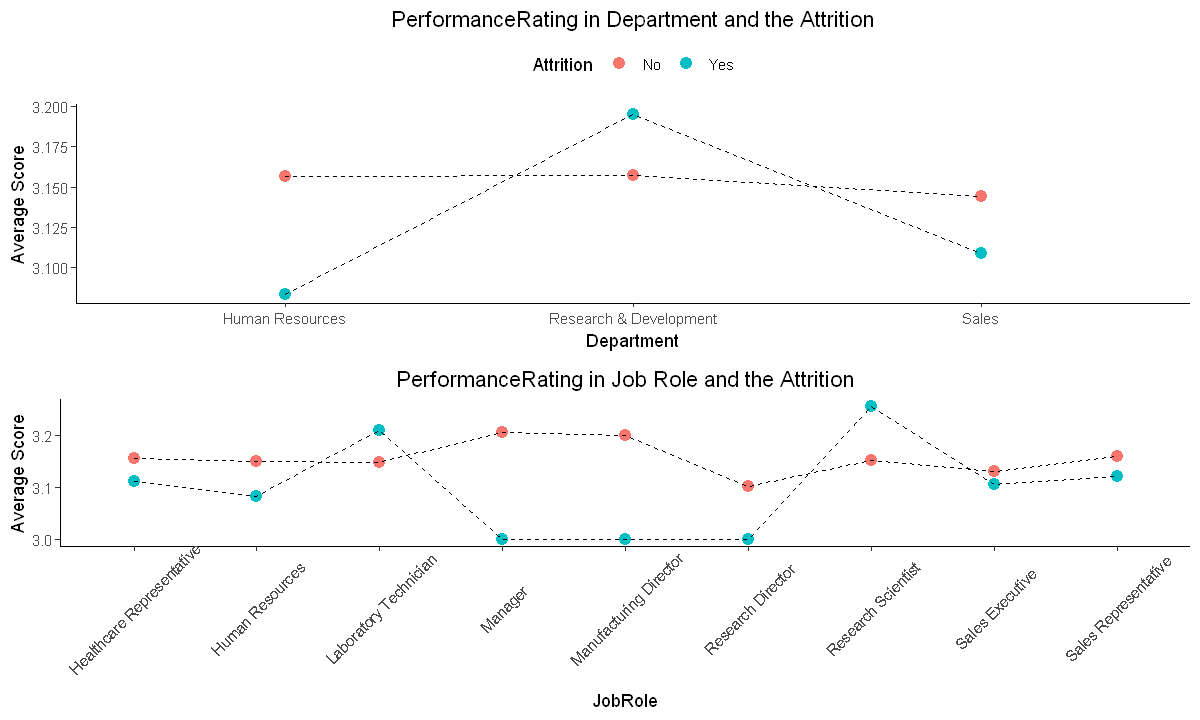

In [286]:
# PerformanceRating
options(repr.plot.width=10, repr.plot.height=6) 

data <- col_factor$aggregate('[
    {
    "$group":{"_id":{"Attrition":"$Attrition", "Department":"$Department"}, 
              "avg":{"$avg":{"$toInt":"$PerformanceRating"}}}
    }
]')
data <- as.data.frame(matrix(unlist(data),byrow=F, nrow(data),ncol(data)+1))
names(data) <- c("Attrition","Department","avg")
data$avg <- as.double(as.character(data$avg))
p1 <- data %>% ggplot(aes(x=Department,y=avg)) + 
    geom_point(aes(color=Attrition),size=3) + geom_line(aes(group=Attrition),linetype='dashed',color='#000000') +
    labs(title="PerformanceRating in Department and the Attrition", y="Average Score") + 
    theme_classic() + theme(plot.title=element_text(hjust=0.5), legend.position = "top")

data <- col_factor$aggregate('[
    {
    "$group":{"_id":{"Attrition":"$Attrition", "JobRole":"$JobRole"}, 
              "avg":{"$avg":{"$toInt":"$PerformanceRating"}}}
    }
]')
data <- as.data.frame(matrix(unlist(data),byrow=F, nrow(data),ncol(data)+1))
names(data) <- c("Attrition","JobRole","avg")
data$avg <- as.double(as.character(data$avg))
p2 <- data %>%  ggplot(aes(x=JobRole,y=avg)) + 
    geom_point(aes(color=Attrition),size=3) + geom_line(aes(group=Attrition),linetype='dashed',color='#000000') + 
    labs(title="PerformanceRating in Job Role and the Attrition", y="Average Score") +
    theme_classic() + theme(plot.title=element_text(hjust=0.5),axis.text.x = element_text(angle = 45,vjust=0.6), legend.position = 'none')
plot_grid(p1,p2,nrow=2)

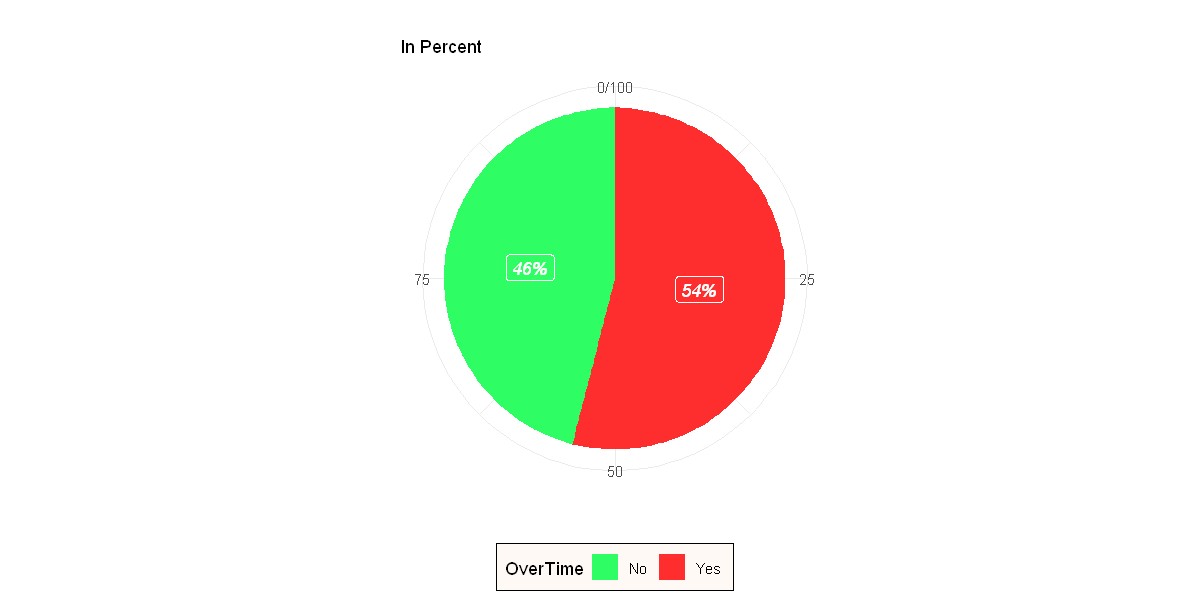

In [300]:
options(repr.plot.width=10, repr.plot.height=5) 

data <- col_factor$aggregate('[
    {
        "$match":{"Attrition":"Yes"}
    },
    {
        "$group":{"_id":"$OverTime", "Count":{"$sum":1}}
    }
]')
names(data) <- c("OverTime","n")

overtime_percent <- data %>% mutate(pct=round(prop.table(n),2) * 100) %>% 
        ggplot(aes(x="", y=pct, fill=OverTime)) + theme_minimal() + 
        geom_bar(width = 1, stat = "identity") + coord_polar("y", start=0) +
        scale_fill_manual(values=c("#2EFE64", "#FE2E2E")) + 
        geom_label(aes(label = paste0(pct, "%")),show.legend = FALSE, position = position_stack(vjust = 0.5), colour = "white",  fontface = "italic")+
        theme(legend.position="bottom", strip.background = element_blank(), strip.text.x = element_blank(), 
        plot.title=element_text(hjust=0.5, color="white"), 
          legend.background = element_rect(fill="#FFF9F5",
                                       size=0.5, linetype="solid", colour ="black")) + 
labs(title="Level of Attrition by Overtime Status", subtitle="In Percent", x="", y="") 

overtime_percent

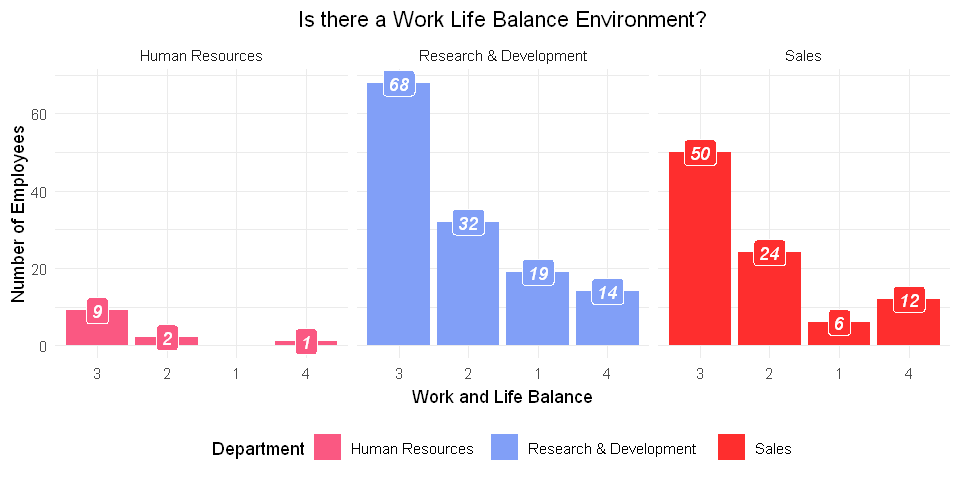

In [304]:
# work life balanced 
options(repr.plot.width=8, repr.plot.height=4)

data <- col_factor$aggregate('[
    {
        "$match":{"Attrition":"Yes"}
    },
    {
        "$group":{"_id":{"Department":"$Department","WorkLifeBalance":"$WorkLifeBalance"}, "Count":{"$sum":1}}
    }
]')
data <- as.data.frame(matrix(unlist(data),byrow=F, nrow(data),ncol(data)+1))
names(data) <- c("Department","WorkLifeBalance","count")
data$count <- as.integer(as.character(data$count))
by.department <- data %>% 
        ggplot(aes(x=reorder(WorkLifeBalance, -count), y=count, fill=Department)) + geom_bar(stat='identity') + facet_wrap(~Department) +
        theme_minimal()+ 
        theme(legend.position="bottom", plot.title=element_text(hjust=0.5)) + 
        scale_fill_manual(values=c("#FA5882", "#819FF7", "#FE2E2E")) + 
        geom_label(aes(label=count, fill = Department), colour = "white", fontface = "italic", show.legend = FALSE) + 
        labs(title="Is there a Work Life Balance Environment?", x="Work and Life Balance", y="Number of Employees")

by.department

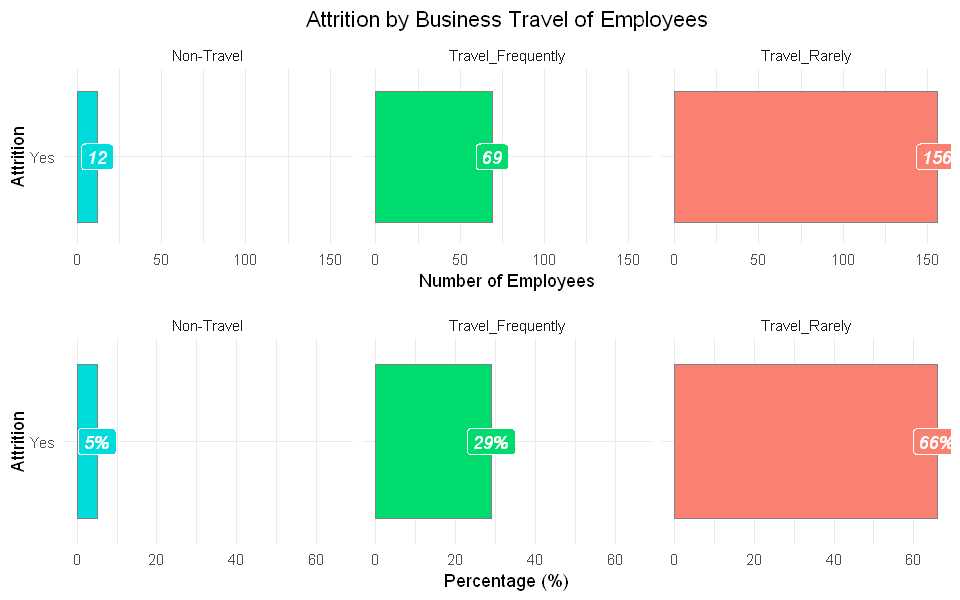

In [308]:
# Business Travel
options(repr.plot.width=8, repr.plot.height=5)


# Percent Attrition by Work Life Balance

data <- col_factor$aggregate('[
    {
        "$match":{"Attrition":"Yes"}
    },
    {
        "$group":{"_id":{"Attrition":"$Attrition","BusinessTravel":"$BusinessTravel"}, "Count":{"$sum":1}}
    }
]')
data <- as.data.frame(matrix(unlist(data),byrow=F, nrow(data),ncol(data)+1))
names(data) <- c("Attrition","BusinessTravel","count")
data$count <- as.integer(as.character(data$count))
work_bal_cnt <- data %>%  mutate(pct=round(prop.table(count),2) * 100) %>%
    ggplot(aes(x=Attrition, y=count, fill=BusinessTravel, color=Attrition)) + geom_bar(stat='identity') + facet_wrap(~BusinessTravel) + 
    geom_label(aes(label=count, fill = BusinessTravel), colour = "white", fontface = "italic")  + theme_minimal() + theme(legend.position="none") + 
    scale_fill_manual(values=c("#00dbdb", "#00db6e", "#fa8072")) +
    scale_color_manual(values=c("#808080", "#808080")) + labs(title="Attrition by Business Travel of Employees", 
                                                          x="Attrition", y="Number of Employees") + coord_flip() + 
theme(plot.title=element_text(hjust=0.5)) 
        
# work_bal_cnt

work_bal_pct <- data %>% mutate(pct=round(prop.table(count),2) * 100) %>%
    ggplot(aes(x=Attrition, y=pct, fill=BusinessTravel, color=Attrition)) + geom_bar(stat='identity') + facet_wrap(~BusinessTravel) + theme_minimal() +  
    theme(legend.position="none") + 
    geom_label(aes(label=paste0(pct, "%"), fill = BusinessTravel), colour = "white", fontface = "italic")  + 
    scale_fill_manual(values=c("#00dbdb", "#00db6e", "#fa8072")) +
    scale_color_manual(values=c("#808080", "#808080")) + labs(x="Attrition", y="Percentage (%)") + coord_flip() + 
    theme()

plot_grid(work_bal_cnt, work_bal_pct, nrow=2)

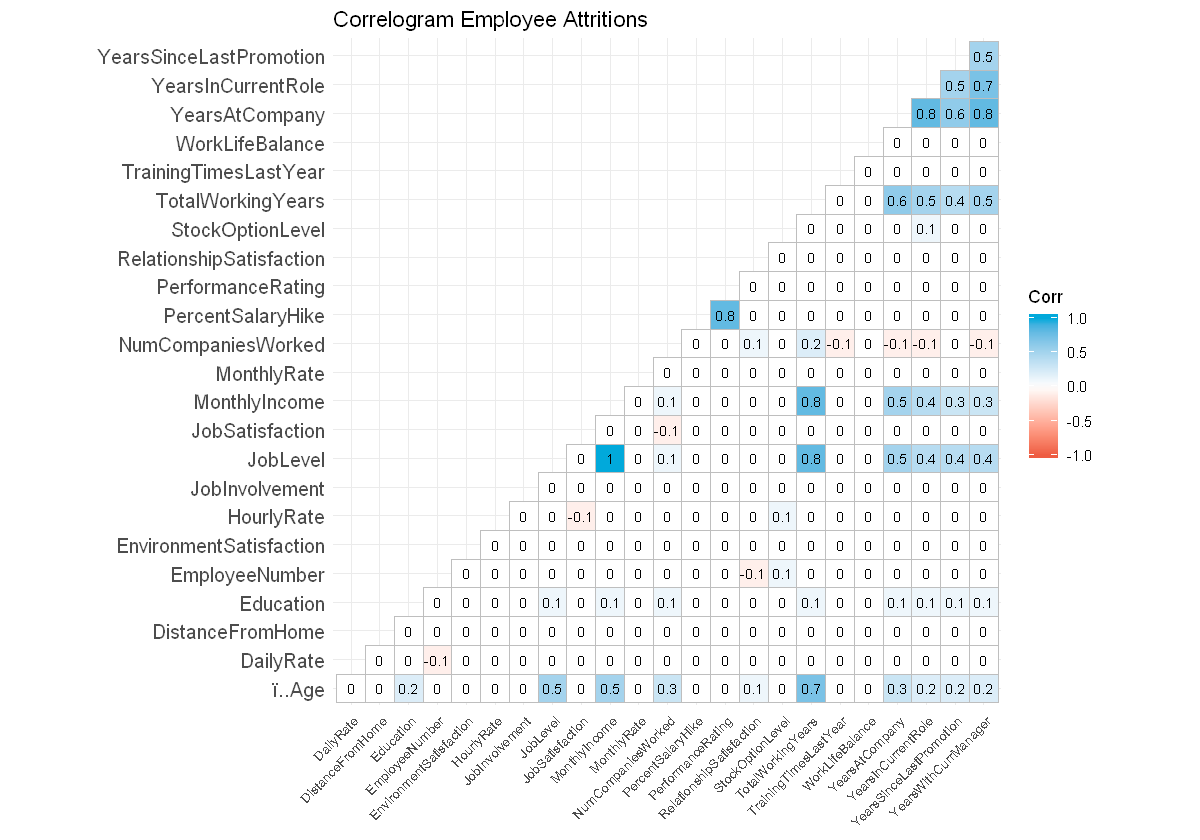

In [309]:
# correlogram
options(repr.plot.width=10, repr.plot.height=7) 
nums <- select_if(data_raw,is.numeric)
corr <- round(cor(nums),1)

ggcorrplot(corr,type = 'lower',lab=TRUE, lab_size=3, method='square',
          colors=c('tomato2','white','#01A9DB'),
          title='Correlogram Employee Attritions') + theme(axis.text.x = element_text(angle = 45,size = 8))

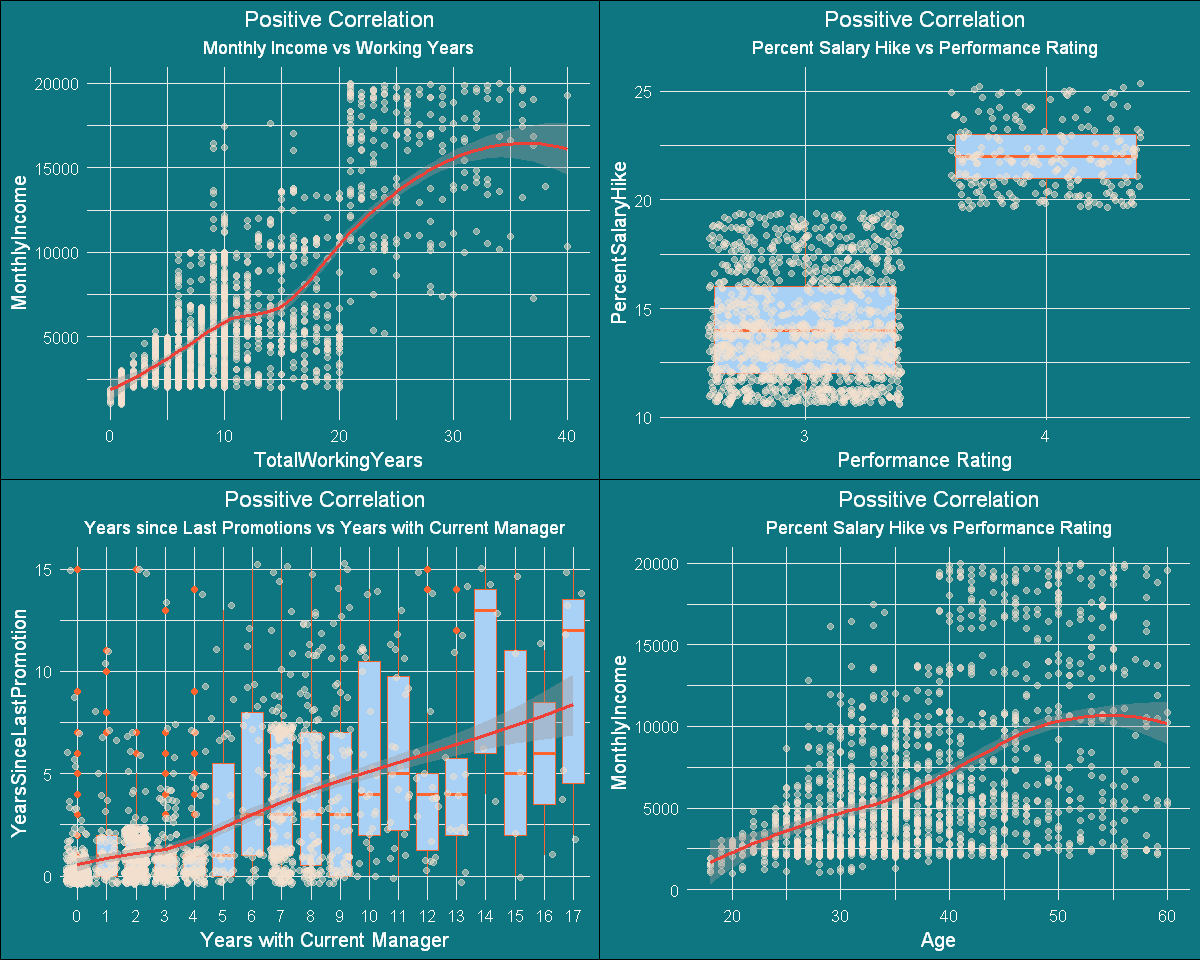

In [315]:
options(repr.plot.width=10, repr.plot.height=8) 
# positive correlation
data <- col_numeric$find(fields='{"_id":0,"TotalWorkingYears":1,"MonthlyIncome":1}')
p1 <- data %>% ggplot(aes(x=TotalWorkingYears,y=MonthlyIncome)) + 
    geom_point(colour="#F2DFCE", alpha=0.5) + geom_smooth(method = 'loess', color="#EE4037") + theme_minimal() + 
    theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5, color="white"), 
        plot.subtitle=element_text(hjust=0.5,color='white'), plot.background=element_rect(fill="#0D7680"),
         axis.title.x=element_text(color='white',size=12), axis.text.x=element_text(color='white', size=10),
         axis.title.y=element_text(color='white',size=12), axis.text.y=element_text(color='white', size=10)) + 
    labs(title="Positive Correlation", subtitle="Monthly Income vs Working Years")


# year with curr manager and year since the last promotion
data <- col_numeric$find(fields='{"_id":0,"YearsWithCurrManager":1,"YearsSinceLastPromotion":1}')
p3 <- data %>%
    ggplot(aes(x=factor(YearsWithCurrManager),y=YearsSinceLastPromotion)) + geom_boxplot(color="#FE642E",fill="#A9D0F5") +
    geom_jitter(color="#F2DFCE",alpha=0.5) + geom_smooth(method = 'loess',color="#EE4037",aes(group=1)) + theme_minimal() + 
    theme(plot.background=element_rect(fill="#0D7680"),plot.title = element_text(hjust = 0.5, color="white"), 
        plot.subtitle=element_text(hjust=0.5,color='white'),
         axis.title.x=element_text(color='white',size=12), axis.text.x=element_text(color='white', size=10),
         axis.title.y=element_text(color='white',size=12), axis.text.y=element_text(color='white', size=10)) + 
    labs(title="Possitive Correlation",subtitle = "Years since Last Promotions vs Years with Current Manager", 
        x="Years with Current Manager")

data <- col_numeric$aggregate('[
    {
        "$lookup":
            { "from":"hr_factor",
              "localField":"id",
              "foreignField": "id",
              "as":"hr_factor"
            }
    }, 
    {
        "$replaceRoot": { "newRoot": { "$mergeObjects": [ { "$arrayElemAt": [ "$hr_factor", 0 ] }, "$$ROOT" ] } }
    },
    {
        "$project": { "hr_factor": 0} 
    },
    {
        "$project":{"_id":0, "PerformanceRating":1,"PercentSalaryHike":1}
    }
]')

p2 <- data %>% ggplot(aes(x=factor(PerformanceRating),y=PercentSalaryHike)) + 
    geom_boxplot(color="#FE642E", fill="#A9D0F5") + geom_jitter(color="#F2DFCE", alpha=0.5) + theme_minimal() + 
    theme(plot.background=element_rect(fill="#0D7680"),plot.title = element_text(hjust = 0.5, color="white"), 
        plot.subtitle=element_text(hjust=0.5,color='white'),
         axis.title.x=element_text(color='white',size=12), axis.text.x=element_text(color='white', size=10),
         axis.title.y=element_text(color='white',size=12), axis.text.y=element_text(color='white', size=10)) + 
    labs(title="Possitive Correlation",subtitle = "Percent Salary Hike vs Performance Rating", 
        x="Performance Rating")

data <- col_numeric$find(fields='{"_id":0,"Age":1,"MonthlyIncome":1}')
p4 <- data %>% select(Age,MonthlyIncome) %>% ggplot(aes(x=Age,y=MonthlyIncome)) + geom_point(color="#F2DFCE",alpha=0.5) +
    geom_smooth(method = "loess",color="#EE4037") + theme_minimal() + 
    theme(plot.background=element_rect(fill="#0D7680"),plot.title = element_text(hjust = 0.5, color="white"), 
        plot.subtitle=element_text(hjust=0.5,color='white'),
         axis.title.x=element_text(color='white',size=12), axis.text.x=element_text(color='white', size=10),
         axis.title.y=element_text(color='white',size=12), axis.text.y=element_text(color='white', size=10)) + 
    labs(title="Possitive Correlation",subtitle = "Percent Salary Hike vs Performance Rating", 
        x="Age")

plot_grid(p1,p2,p3,p4,nrow=2)

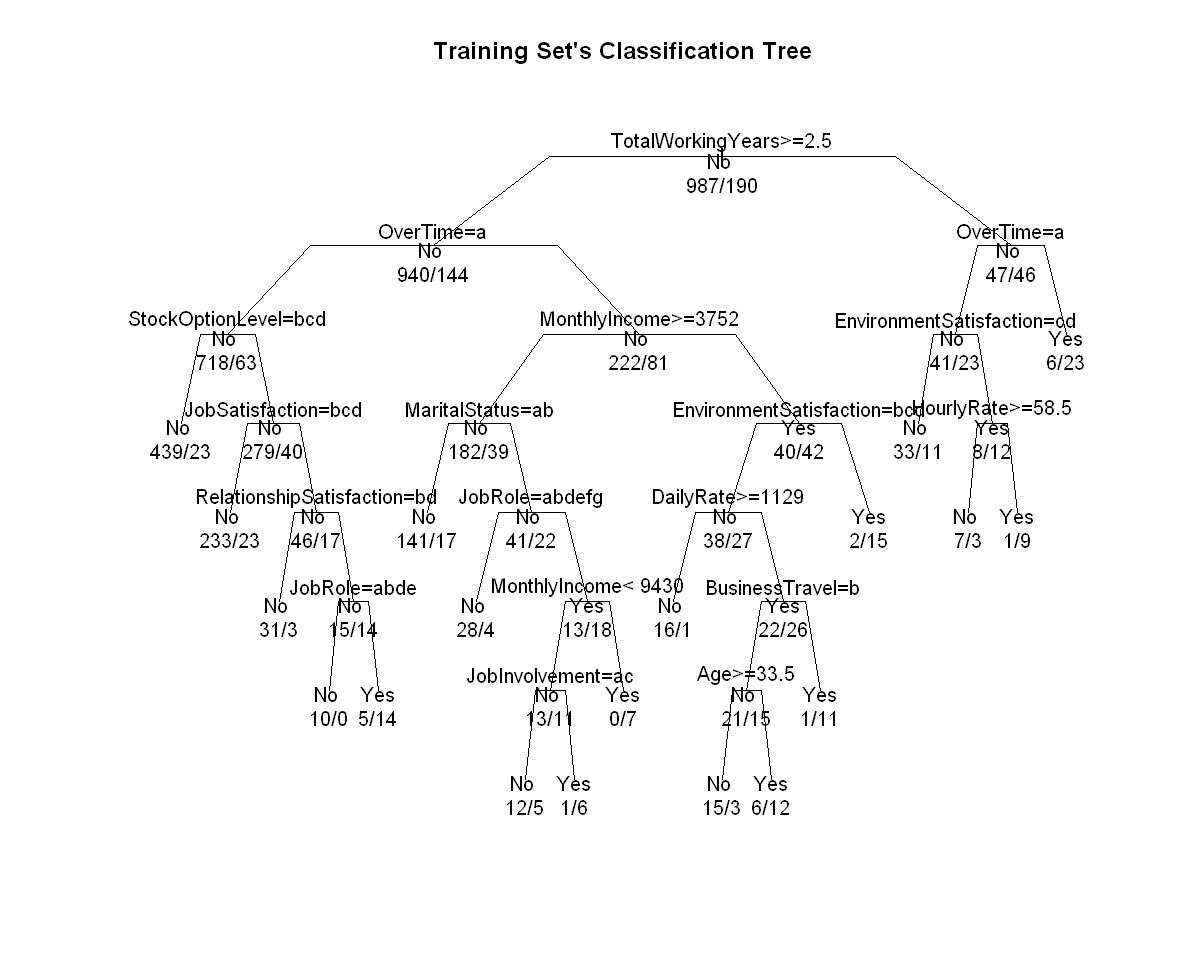

In [337]:
# spliting dataset
set.seed(142)
original_data <- data_raw[sample(nrow(data_raw)),]

# let's encode the factor
original_data$BusinessTravel = factor(original_data$BusinessTravel, 
                                     levels=c('Travel_Frequently', 'Travel_Rarely', 'Non-Travel'),
                                     labels=c(1,2,3))

# change the datatype from integer to factors from ordinal variables
cols <- c("Education", "EnvironmentSatisfaction", "JobInvolvement", "JobLevel",
         "JobSatisfaction", "PerformanceRating", "RelationshipSatisfaction", 
         "StockOptionLevel", "TrainingTimesLastYear", "WorkLifeBalance")

original_data[cols] <- lapply(original_data[cols], factor)

# delete unecessary columns
cols <- c("Over18", "EmployeeNumber", "EmployeeCount")
original_data[cols] <- NULL

# Spliting dataset
train_index <- createDataPartition(original_data$Attrition, p=0.8, list=FALSE, times = 1)

train <- original_data[train_index,]
test <- original_data[-train_index,]

# Checking that both the training and testing sets have the same label proportions
prop_train <- train %>% select(Attrition) %>% group_by(Attrition) %>% summarise(Count=n()) %>% mutate(pct=round(prop.table(Count),2))
prop_test <- test %>% select(Attrition) %>% group_by(Attrition) %>% summarise(Count=n()) %>% mutate(pct=round(prop.table(Count),2))



options(repr.plot.width=10, repr.plot.height=8)

rpart.tree <- rpart(Attrition ~ ., data=train)
plot(rpart.tree, uniform=TRUE, branch=0.6, margin=0.05)
text(rpart.tree, all=TRUE, use.n=TRUE)
title("Training Set's Classification Tree")

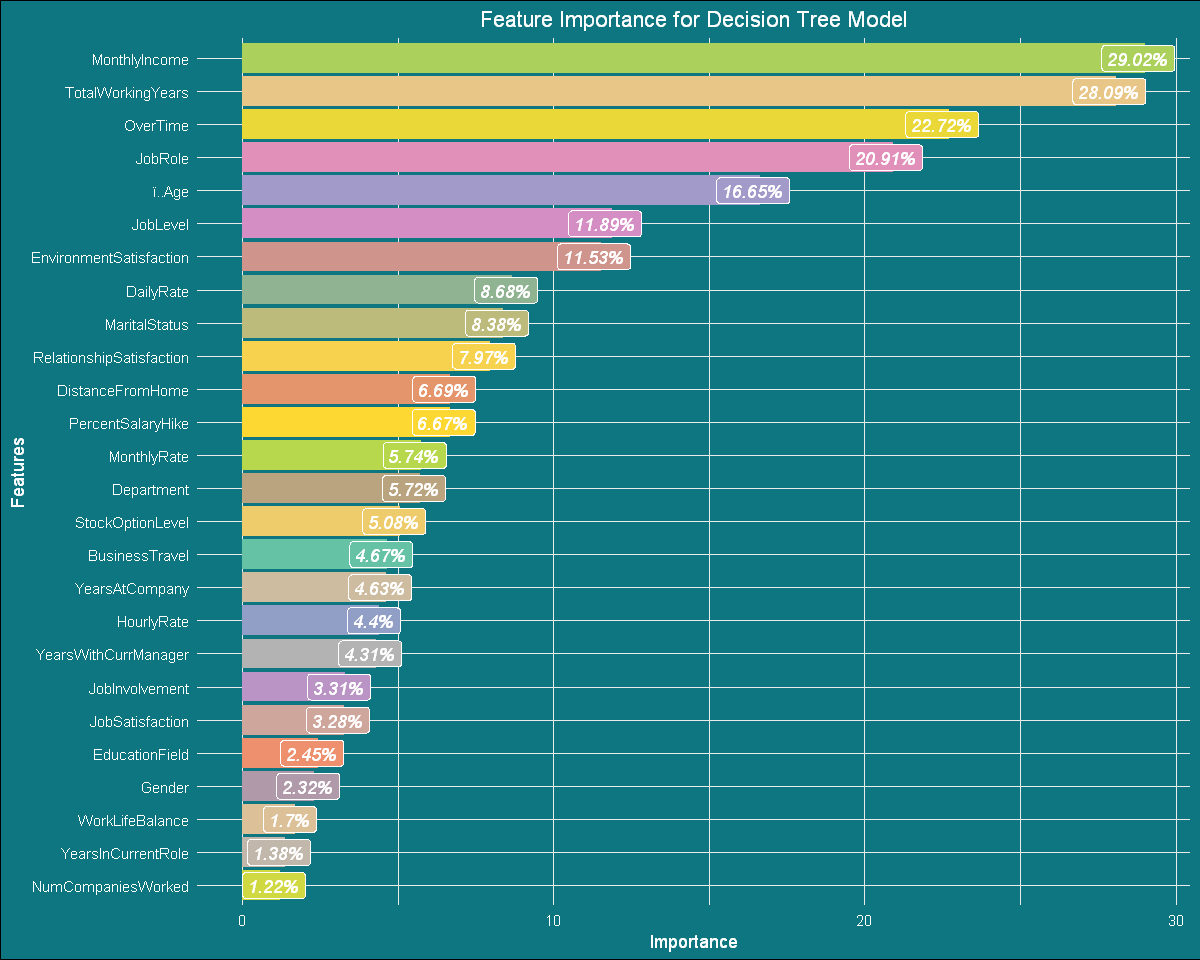

In [318]:
# the most important feature
var_imp <- data.frame(rpart.tree$variable.importance)
var_imp$features <- rownames(var_imp)
var_imp <- var_imp[,c(2,1)]
var_imp$importance <- round(var_imp$rpart.tree.variable.importance,2)
var_imp$rpart.tree.variable.importance <- NULL

options(repr.plot.width=10, repr.plot.height=8)
colorCount <- length(unique(var_imp$features))
feature_importance <- var_imp %>% ggplot(aes(x=reorder(features,importance),y=importance, fill=features)) + 
    geom_bar(stat = 'identity') + coord_flip() + theme_minimal() + 
    theme(legend.position = 'none',plot.title = element_text(hjust = 0.5, color = 'white'), plot.subtitle = element_text(hjust = 0.5, color = 'white'),
         plot.background=element_rect(fill="#0D7680"), axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
         axis.title=element_text(colour="white"),legend.background=element_rect(fill="#FFF9F5",size=0.5, linetype = "solid",
         color='black')) + scale_fill_manual(values = colorRampPalette(brewer.pal(24, "Set2"))(colorCount)) + 
         geom_label(aes(label=paste0(importance, "%")), colour = "white", fontface = "italic", hjust=0.6) + 
        labs(title="Feature Importance for Decision Tree Model", x="Features", y="Importance")
feature_importance

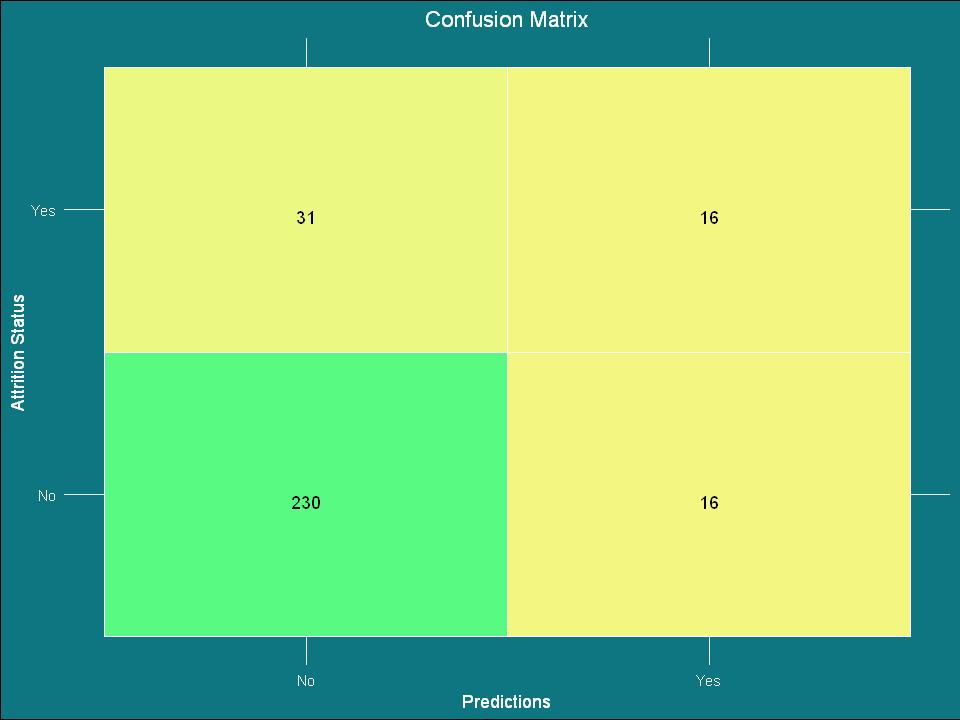

In [319]:
# prediction with confusion matrix
options(repr.plot.width=8, repr.plot.height=6)
test.features <- test %>% select(-Attrition)

predictions <- predict(rpart.tree, test.features, type="class")
conf_df <- data.frame(table(test$Attrition, predictions))

ggplot(data=conf_df, mapping = aes(x=predictions,y=Var1)) + 
    geom_tile(aes(fill=Freq), colour='white') + 
    geom_text(aes(label=sprintf("%1.0f", Freq)), vjust= 1) + 
    scale_fill_gradient(low="#F3F781", high="#58FA82") + theme_minimal() +
    theme(legend.position="none", strip.background = element_blank(), strip.text.x = element_blank(), 
          plot.title=element_text(hjust=0.5, color="white"), plot.subtitle=element_text(color="white"), 
          plot.background=element_rect(fill="#0D7680"), axis.text.x=element_text(colour="white"), axis.text.y=element_text(colour="white"),
          axis.title=element_text(colour="white"), legend.background = element_rect(fill="#FFF9F5",
                                  size=0.5, linetype="solid", 
                                  colour ="black")) + 
labs(title="Confusion Matrix", y="Attrition Status", x="Predictions")

In [320]:
roc.curve(test$Attrition, predictions, plotit = F)

Area under the curve (AUC): 0.638

In [338]:
# over sampling
data_balanced_over <- ovun.sample(Attrition ~ ., data=train, method='over', N = 1960)$data

# under sampling
data_balanced_under<- ovun.sample(Attrition ~ ., data=train, method='under', N=376, seed=1)$data

# both sampling
data_balanced_both <- ovun.sample(Attrition ~ ., data=train, method='both', p=0.5)$data

# using ROSE package
data.rose <- train
data.rose$Educational_Levels <- as.factor(data.rose$Educational_Levels)
data.rose$CatYearManager <- as.factor(data.rose$CatYearManager)
data.rose <- ROSE(Attrition ~ ., data=data.rose, seed=1)$data

In [339]:
tree.rose <- rpart(Attrition ~., data=data.rose)
tree.over <- rpart(Attrition ~., data=data_balanced_over)
tree.under <- rpart(Attrition ~., data=data_balanced_under)
tree.both <- rpart(Attrition ~., data=data_balanced_both)

In [340]:
test.rose <- test
test.rose$Educational_Levels <- as.factor(test.rose$Educational_Levels)
test.rose$CatYearManager <- as.factor(test.rose$CatYearManager)
pred.tree.rose <- predict(tree.rose, test.rose, type='class')

pred.tree.over <- predict(tree.over, test, type='class')
pred.tree.under <- predict(tree.under, test, type='class')
pred.tree.both <- predict(tree.both, test, type='class')

In [341]:
roc.curve(test$Attrition,pred.tree.over, plotit = F)
roc.curve(test$Attrition,pred.tree.under, plotit = F)
roc.curve(test$Attrition,pred.tree.both, plotit = F)
roc.curve(test$Attrition,pred.tree.rose, plotit = F)

Area under the curve (AUC): 0.683

Area under the curve (AUC): 0.648

Area under the curve (AUC): 0.713

Area under the curve (AUC): 0.736

In [342]:
confusionMatrix(test$Attrition, predictions)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  230  16
       Yes  31  16
                                          
               Accuracy : 0.8396          
                 95% CI : (0.7925, 0.8797)
    No Information Rate : 0.8908          
    P-Value [Acc > NIR] : 0.99706         
                                          
                  Kappa : 0.3162          
                                          
 Mcnemar's Test P-Value : 0.04114         
                                          
            Sensitivity : 0.8812          
            Specificity : 0.5000          
         Pos Pred Value : 0.9350          
         Neg Pred Value : 0.3404          
             Prevalence : 0.8908          
         Detection Rate : 0.7850          
   Detection Prevalence : 0.8396          
      Balanced Accuracy : 0.6906          
                                          
       'Positive' Class : No              
                              

In [343]:
train$Educational_Levels <- as.factor(train$Educational_Levels)
train$CatYearManager <- as.factor(train$CatYearManager)
train <- train %>% filter(!is.na(Generation))
test <- test %>% filter(!is.na(Generation))
test$Educational_Levels <- as.factor(test$Educational_Levels)
test$CatYearManager <- as.factor(test$CatYearManager)

## decision tree with all value, no cross validation

In [344]:
rpart.tree <- rpart(Attrition ~ ., data=train)
test.features <- test %>% select(-Attrition)
predictions <- predict(rpart.tree, test.features, type='class')
confusionMatrix(predictions, test$Attrition)
roc.curve(predictions,test$Attrition,plotit = F)

Confusion Matrix and Statistics

          Reference
Prediction  No Yes
       No  229  34
       Yes  15  12
                                          
               Accuracy : 0.831           
                 95% CI : (0.7828, 0.8723)
    No Information Rate : 0.8414          
    P-Value [Acc > NIR] : 0.71735         
                                          
                  Kappa : 0.2395          
                                          
 Mcnemar's Test P-Value : 0.01013         
                                          
            Sensitivity : 0.9385          
            Specificity : 0.2609          
         Pos Pred Value : 0.8707          
         Neg Pred Value : 0.4444          
             Prevalence : 0.8414          
         Detection Rate : 0.7897          
   Detection Prevalence : 0.9069          
      Balanced Accuracy : 0.5997          
                                          
       'Positive' Class : No              
                              

Area under the curve (AUC): 0.658

## decision tree with all value, cross validation

In [ ]:
# let's try with grid search and cross validation 
train.cr.features <- train %>% select(-Attrition)
train.cr.labels <- train$Attrition

trainCtr <- trainControl(method = 'repeatedcv', number = 10, repeats = 3)
model <- train(train.cr.features, train.cr.labels, method='rpart',trControl = trainCtr, metric = 'Accuracy', tuneLength=15)

test.features <- test %>% select(-Attrition)
test.labels <- test$Attrition

cr.prediction <- predict(model, test.features)

confusionMatrix(cr.prediction, test.labels)
roc.curve(cr.prediction, test.labels, plotit = F)

## decision tree with important value, cross validation

In [ ]:
# only importance features with decision tree, cross validation
train_selected_features <- train %>% select(Attrition, MonthlyIncome, Age, OverTime, JobRole, TotalWorkingYears)
test_selected_features <- test %>% select(Attrition, MonthlyIncome, Age, OverTime, JobRole, TotalWorkingYears)

train.cr.features <- train_selected_features %>% select(-Attrition)
train.cr.labels <- train_selected_features$Attrition

trainCtr <- trainControl(method = 'repeatedcv', number = 10, repeats = 3)
model <- train(train.cr.features, train.cr.labels, method='rpart',trControl = trainCtr, metric = 'Accuracy', tuneLength=15)

test.features <- test_selected_features %>% select(-Attrition)
test.labels <- test_selected_features$Attrition

cr.prediction <- predict(model, test.features)

confusionMatrix(cr.prediction, test.labels)
roc.curve(cr.prediction, test.labels, plotit=F)

## random forest with all the features, cross validation

In [ ]:
# let's try with grid search and cross validation and rf 

train.cr.features <- train %>% select(-Attrition)
train.cr.labels <- train$Attrition

trainCtr <- trainControl(method = 'repeatedcv', number = 10, repeats = 3)
model <- train(train.cr.features, train.cr.labels, method='rf',trControl = trainCtr, metric = 'Accuracy', tuneLength=15)

test.cr.features <- test %>% select(-Attrition)
test.cr.labels <- test$Attrition
data.cr.prediction <- predict(model, test.cr.features)

confusionMatrix(data.cr.prediction, test.cr.labels)
roc.curve(data.cr.prediction, test.cr.labels,plotit = F)

## Random Forest with important features, cross validation 

In [ ]:
# let's try with grid search and cross validation with selected feature
train_selected_features <- train %>% select(Attrition, MonthlyIncome, Age, OverTime, JobRole, TotalWorkingYears)
test_selected_features <- test %>% select(Attrition, MonthlyIncome, Age, OverTime, JobRole, TotalWorkingYears)

train.cr.features <- train_selected_features %>% select(-Attrition)
train.cr.labels <- train_selected_features$Attrition

trainCtr <- trainControl(method = 'repeatedcv', number = 10, repeats = 3)
model <- train(train.cr.features, train.cr.labels, method='rf',trControl = trainCtr, metric = 'Accuracy', tuneLength=15)

test.cr.labels <- test_selected_features$Attrition
test.cr.features <- test_selected_features %>% select(-Attrition)

data.cr.prediction <- predict(model, test.cr.features)

confusionMatrix(data.cr.prediction, test.cr.labels)
roc.curve(data.cr.prediction, test.cr.labels, plotit = F)